In [1]:
%run /Desktop/Share/CUDA_DEVICE_setup.py -n 1

using GPU ID:0,



In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
import sys
import random
import time
from sklearn.model_selection import train_test_split
import sklearn

import glob

from torchvision import models
from torchsummary import summary
from thop import profile


for nor_mode in range(0,3):  
    if nor_mode == 1:
        struc ="5L_UNET_50_1channel_Z_50hz"
    elif nor_mode == 2:
        struc ="5L_UNET_50_1channel_MAX_50hz"
    else:
        struc ="5L_UNET_50_1channel_nNor_50hz"
        
    path = 'pic/'+struc+"/"
    if not os.path.isdir(path):
        os.makedirs(path)
    path = 'model/'+struc+"/"
    if not os.path.isdir(path):
        os.makedirs(path)

data_dir = 'dataset_50/'

test_run = ["00","01","02","03"]
print (test_run)


path = 'pic/'+struc+"/"
if not os.path.isdir(path):
    os.makedirs(path)
path = 'model/'+struc+"/"
if not os.path.isdir(path):
    os.makedirs(path)

['00', '01', '02', '03']


# Parameter

In [3]:

##parameter 
global iteration,N_batch
print('\033[1;31;48m' )   #31 red test 40 black background
# epoch = int(input("epoch : ") )  
# N_batch = int(input("batch : ") ) 
# early_step = int(input("early : "))

print('\033[0m' ) #default setting

LR = 0.01
epoch = 300
N_batch = 300
early_step = 250



# Draw

In [4]:
def draw_loss(loss_train,loss_val):
    global file_name
    t=np.arange(0,len(loss_train))
    loss_train = np.array(loss_train)
    loss_val = np.array(loss_val)
    %matplotlib inline
    plt.plot(t,loss_train,'b-',label = "Train")
    plt.plot(t,loss_val,'r-',label = "Validation")
    
    plt.title('Train Val History')
    plt.ylabel("Loss(Cross Entropy)")
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
#     plt.savefig(('pic/'+struc+'/'+file_name+"_learning.png"),dpi=800,format="png")
    plt.show(block="True")  
    
    plt.close()

In [5]:
def draw_acc(acc_train,acc_val):
    global file_name
    t=np.arange(0,len(acc_train))
    loss_train = np.array(acc_train)
    loss_val = np.array(acc_val)
    %matplotlib inline
    plt.plot(t,acc_train,'b-',label = "Train")
    plt.plot(t,acc_val,'r-',label = "Validation")
    
    plt.title('Train Val History')
    plt.ylabel("Acc")
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
#     plt.savefig(('pic/'+struc+'/'+file_name+"_Train_ACC.png"),dpi=800,format="png")
    plt.show(block="True") 

    plt.close()

In [6]:
def bad_filename(filename):
    temp = filename.encode(sys.getfilesystemencoding(), errors='surrogateescape')
    return temp.decode('utf-8')

# Read file

In [7]:
def read_file(p): #read sensor
    global test_run

    train_i = []
    train_g = []
    test_i = []
    test_g = []
    ## run 

    for i in range(len(test_run)):
        f = glob.glob(r'dataset_50_50Hz_overlap1/'+test_run[i]+'/label/*.csv')
        for a in range(0,len(f)):
            sensor_split = f[a].split("/")

            sensor_split[-2] = "sensor"
            sensor_file = "/".join(sensor_split)
            file_name = sensor_split[-1]
            file_name = bad_filename(file_name)

            if test_run[i] == p : 

                csv_file = open(f[a],'r')
                row = []
                sensor  = []
                ground = []
                for row in csv.reader(csv_file):
                    if(len(row)!=0):
                        ground.append(row)
                        ground.append(row)
                        ground.append(row)
                        ground.append(row)
                        ground.append(row)
                        ground.append(row)
                test_g.append(ground)        
                csv_file = open(sensor_file,'r')
                for row in csv.reader(csv_file):
                    if(len(row)!=0):
                        sensor.append(row)
                        
                test_i.append(sensor)
            else:
                csv_file = open(f[a],'r')
                row = []
                sensor  = []
                ground = []
                for row in csv.reader(csv_file):
                    if(len(row)!=0):
                        ground.append(row)
                        ground.append(row)
                        ground.append(row)
                        ground.append(row)
                        ground.append(row)
                        ground.append(row)
                train_g.append(ground)
                csv_file = open(sensor_file,'r')
                
                for row in csv.reader(csv_file):
                    if(len(row)!=0):
                        sensor.append(row)
                train_i.append(sensor)


    return train_i,train_g,test_i,test_g

# Accuracy

In [8]:
def accuaracy(ouput_from_nn,ground_truth):
    acc = 0
    acc_temp = 0
    for i in range(ouput_from_nn.shape[0]):
        label_nn = np.argmax(ouput_from_nn[i],0)
        for a in range(0,6):
            acc_temp = sklearn.metrics.accuracy_score(label_nn[a], ground_truth[i][a]) +  acc_temp
        acc_temp = acc_temp / 6
        
        acc = acc + acc_temp
        acc_temp = 0
#         print (label_nn)
#         print (ground_truth[i])
#         print ("AC",sklearn.metrics.accuracy_score(label_nn[0], ground_truth[i][0]))
#     print (acc/ouput_from_nn.shape[0])
    return acc/ouput_from_nn.shape[0]
#         print "label:",label_nn
#         print "ground:",ground_truth[i]


# Tensor Data 

In [9]:
class TensorDataset():
    """Dataset wrapping data and target tensors.

    Each sample will be retrieved by indexing both tensors along the first
    dimension.

    Arguments:
        data_tensor (Tensor): contains sample data.
        target_tensor (Tensor): contains sample targets (labels).
    """
    def __init__(self, data_tensor, target_tensor):
        assert data_tensor.size(0) == target_tensor.size(0)
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.data_tensor[index], self.target_tensor[index]

    def __len__(self):
        return self.data_tensor.size(0)

# load_dataset

In [10]:
def load_dataset(t):#p for testing
    global nor_mode
    train_data  = []
    train_truth = [] 
    test_data = []
    test_truth = []
#     for i in range(len(act)):
    print("----Loading data...")
    train_i,train_g,test_i,test_g = read_file(t)
    train_data.extend(train_i)
    train_truth.extend(train_g)
    test_data.extend(test_i)
    test_truth.extend(test_g)
#     for i in range(len(people)):
#         w_tr_i,w_tr_g,w_t_i,w_t_g = walk_file(people[i])
#         train_data.extend(w_tr_i)
#         train_truth.extend(w_tr_g)
#         test_data.extend(w_t_i)
#         test_truth.extend(w_t_g)

            
    train_data = np.array(train_data, dtype = np.float32)
    train_ground = np.array(train_truth, dtype = np.float32)
    test_data = np.array(test_data, dtype = np.float32)
    test_ground = np.array(test_truth, dtype = np.float32)
    print("train_data shape:",train_data.shape)
    print("train_ground shape:",train_ground.shape)
    print("test_data shape:",test_data.shape)
    print("test_ground shape:",test_ground.shape)
    print("----Loading DONE!")
    print("----Normalized...")
    if nor_mode == 1:
        train_data,test_data = Z_normalize(train_data,test_data)
    elif nor_mode == 2:
        train_data,test_data = Max_normalize(train_data,test_data)
    else :
        train_data,test_data = train_data,test_data
    print("----Normalized Done")

    return train_data,train_ground,test_data,test_ground

# Normalized

In [11]:
def Z_normalize(train_data,test_data):
#     
    train_data_new = train_data
    test_data_new = test_data
    

    for i in range(6):
        data = train_data[:,i,:]
        mean = np.mean(data)
        std = np.std(data)
        data_new = ( data - mean )/ std
        train_data_new[:,i,:] = data_new

        data = test_data[:,i,:]
        mean = np.mean(data)
        std = np.std(data)
        data_new = ( data - mean )/ std
        test_data_new[:,i,:] = data_new

    return train_data_new,test_data_new

    



In [12]:
def Max_normalize(train_data,test_data):
#     
    train_data_new = train_data
    test_data_new = test_data
    
#     print (train_data_new[:,0,:])
    for i in range(3):
        data = train_data[:,i,:]
        data_new = data / 16
        train_data_new[:,i,:] = data_new
        
        data = test_data[:,i,:]
        data_new = data / 16
        test_data_new[:,i,:] = data_new
    for i in range(3,6):
        data = train_data[:,i,:]
        data_new = data / 2000
        train_data_new[:,i,:] = data_new

        data = test_data[:,i,:]
        data_new = data / 2000
        test_data_new[:,i,:] = data_new
#     print (train_data_new[:,0,:])
    return train_data_new,test_data_new

    



# Early Stop

In [13]:
def Early_stop(model,monitor,patience):
    global early_acc
    global step
    global early_model
    if monitor >= early_acc:
        early_acc = monitor
        early_model = model
        step = 0
    else :
        step +=1
#     print "Step:",step
#     print "Early_acc:",early_acc
    return early_model,step, early_acc

# UNET_RUN

In [14]:
def UNET_run(t,input_f,ground,test_input,test_ground):
#     global file_name,input_f,ground,test_input,test_ground
    global U_net
    U_net = Unet(1,2)
    U_net.cuda()
    
########### calculate FLOPS and param. num #######################    
    input = torch.randn(300,1,6,50).cuda()
    flops, params = profile(U_net, inputs=(input, ))  
    print("flops: ", '%.6f'%flops)
    print("params: ", '%.6f'%params)
##################################################################
    
    pytorch_total_params = sum(p.numel() for p in U_net.parameters())
    print("Para num :",pytorch_total_params)   
    
    train_input = np.array(input_f,dtype=np.float32)[:,np.newaxis,:]   
    train_label = np.array(ground,dtype=np.int64)#[:,np.newaxis]     
  
    test_input = np.array(test_input,dtype=np.float32)[:,np.newaxis,:] 
    test_label = np.array(test_ground,dtype=np.int64)

    train_label = train_label.reshape(train_label.shape[0],6,50)

    test_label = test_label.reshape(test_ground.shape[0],6,50)
    print ("Train input:",train_input.shape)
    print ("Train label:",train_label.shape)

    print ("Test input:",test_input.shape)
    print ("Test label:",test_label.shape)
 
    train_input = torch.from_numpy(train_input)
    train_label = torch.from_numpy(train_label)
    test_input = torch.from_numpy(test_input)
    test_label = torch.from_numpy(test_label)
    
    np.save("torch_train_input", train_input)
    
    torch_dataset = TensorDataset(data_tensor=train_input, target_tensor=train_label )
    test_dataset = TensorDataset(data_tensor=test_input, target_tensor=test_label )
    loader = Data.DataLoader(
        dataset=torch_dataset,      # torch TensorDataset format
        batch_size=N_batch,      # mini batch size
        shuffle=True,               # random shuffle for training
        num_workers=2,              # subprocesses for loading data
    )
    test_loader = Data.DataLoader(
        dataset=test_dataset,      # torch TensorDataset format
        batch_size=N_batch,      # mini batch size
        shuffle=True,               # random shuffle for training
        num_workers=2,              # subprocesses for loading data
    )

    optimizer = torch.optim.Adam(U_net.parameters(), lr=LR)#,  weight_decay = 0.001)
    loss_func = nn.CrossEntropyLoss()

    loss_train = []
    loss_val = []
    acc_train = []
    acc_val = []

    for i in range(epoch):
        loss_epoch = 0
        acc = 0
        acc_t = 0
        loss_t = 0
        ticks = time.time()
        for step, (input_f, ground) in enumerate(loader):   # gives batch data, normalize x when iterate train_loader

            data = Variable(input_f).cuda()   # batch x
            label = Variable(ground).cuda()   # batch y

            output = U_net(data)               # cnn output include x,y,z 
            output_numpy = output.cpu().data.numpy()
            ground_ = ground.numpy()
            acc = acc + accuaracy(output_numpy,ground_)
            loss = loss_func(output, label)   
            loss_epoch = loss_epoch + float(loss)# caculate for display

            optimizer.zero_grad()           # clear gradients for this training step
            loss.backward()                 # backpropagation, compute gradients
            optimizer.step()                # apply gradients

        loss_epoch = loss_epoch/(step+1)
        acc = acc/(step+1)
        loss_train.append(loss_epoch)
        acc_train.append(acc)
        
        
        for step, (input_f, ground) in enumerate(test_loader):   # gives batch data, normalize x when iterate train_loader

            data = Variable(input_f).cuda()   # batch x
            label = Variable(ground).cuda()   # batch y

            output = U_net(data)               # cnn output include x,y,z 
            output_numpy = output.cpu().data.numpy()
            ground_ = ground.numpy()
            acc_t = acc_t + accuaracy(output_numpy,ground_)
            loss = loss_func(output, label)   
            loss_t = loss_t + float(loss)# caculate for display

        loss_t = loss_t/(step+1)
        acc_t = acc_t/(step+1)
        loss_val.append(loss_t)
        acc_val.append(acc_t)

        run_time = time.time()-ticks
        
        print ('Epoch: {ep} {N} Loss: {t_l:.4f} {N} Acc: {A_tr:.4f}  {N} Test_loss:{T_los:.4f} {N} Test_Acc:{T_acc:.4f} {N} Time:{t:.4f} sec'.format( 
            ep  = i,t_l = loss_epoch, A_tr = acc,t = run_time, T_acc = acc_t , T_los = loss_t ,N ='\033[1;31;48m||\033[0m'))
    
        
#         save_model,break_count,e_acc = Early_stop(cnn,acc_V,early_step)
#         if break_count>= early_step:
#             print ("\033[1;31;48mEarly_stop!!!!\033[0m"," e_acc:",e_acc,"t_acc:",acc_t)
#             break
    save_model = U_net
#     print ("\033[1;31;48mEarly_stop!!!!\033[0m"," e_acc:",e_acc,"t_acc:",acc_t)

######################## save jit pt model ####################################
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     train_input = train_input.to(device)
#     torch_script_module = torch.jit.trace(save_model, train_input)
#     torch.jit.save(torch_script_module, "Unet_model.pt") 
###############################################################################

#     for param in save_model.parameters(): 
#         print(type(param.data), param.size())
    
    print("torch version: ", torch.__version__)
 
    torch.save(save_model.state_dict(), 'model/'+file_name+'_3L6A_1.pkl') 
    summary(save_model, (1,6,50))
    
    draw_loss(loss_train,loss_val)
    draw_acc(acc_train,acc_val)
    del U_net
#     torch.cuda.empty_cache()

# U-NET


In [15]:
# class DoubleConv(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super(DoubleConv, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_ch, out_ch, (3), padding=1, groups=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(out_ch), 
#             nn.Conv2d(out_ch, out_ch, (3), padding=1, groups=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(out_ch),
            
#         )

#     def forward(self, input):
#         return self.conv(input)

class Unet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Unet, self).__init__()
#         self.conv1 = DoubleConv(in_ch, 64)
        self.conv1_1  = nn.Conv2d(in_ch, 1, (3), padding=1)
        self.relu1_1  = nn.ReLU(inplace=True)
        self.batch1_1 = nn.BatchNorm2d(1)
        self.conv1_2  = nn.Conv2d(1, 1, (3), padding=1)
        self.relu1_2  = nn.ReLU(inplace=True)
        self.batch1_2 = nn.BatchNorm2d(1)
        
        self.pool1 = nn.MaxPool2d(kernel_size=[1,2])
        
#         self.conv2 = DoubleConv(64, 128)
        self.conv2_1  = nn.Conv2d(1, 2, (3), padding=1)
        self.relu2_1  = nn.ReLU(inplace=True)
        self.batch2_1 = nn.BatchNorm2d(2)
        self.conv2_2  = nn.Conv2d(2, 2, (3), padding=1)
        self.relu2_2  = nn.ReLU(inplace=True)
        self.batch2_2 = nn.BatchNorm2d(2)

        self.pool2 = nn.MaxPool2d(kernel_size=[1,2])
        
#         self.conv3 = DoubleConv(128, 256)
        self.conv3_1  = nn.Conv2d(2, 4, (3), padding=1)
        self.relu3_1  = nn.ReLU(inplace=True)
        self.batch3_1 = nn.BatchNorm2d(4)
        self.conv3_2  = nn.Conv2d(4, 4, (3), padding=1)
        self.relu3_2  = nn.ReLU(inplace=True)
        self.batch3_2 = nn.BatchNorm2d(4)


        # 逆卷积，也可以使用上采样
        
        
        self.up8 = nn.ConvTranspose2d(4, 2, (1,2), stride=(1,2),output_padding = (0,1))
#         self.conv8 = DoubleConv(256, 128)
        self.conv8_1  = nn.Conv2d(4, 2, (3), padding=1)
        self.relu8_1  = nn.ReLU(inplace=True)
        self.batch8_1 = nn.BatchNorm2d(2)
        self.conv8_2  = nn.Conv2d(2, 2, (3), padding=1)
        self.relu8_2  = nn.ReLU(inplace=True)
        self.batch8_2 = nn.BatchNorm2d(2)
        
        self.up9 = nn.ConvTranspose2d(2, 1, (1,2), stride=(1,2))
#         self.conv9 = DoubleConv(128, 64)
        self.conv9_1  = nn.Conv2d(2, 1, (3), padding=1)
        self.relu9_1  = nn.ReLU(inplace=True)
        self.batch9_1 = nn.BatchNorm2d(1)
        self.conv9_2  = nn.Conv2d(1, 1, (3), padding=1)
        self.relu9_2  = nn.ReLU(inplace=True)
        self.batch9_2 = nn.BatchNorm2d(1)
        
        self.conv10 = nn.Conv2d(1, out_ch, 1)

    def forward(self, x):
        
#         c1 = self.conv1(x)############ conv1 ###################
        c1_1 = self.conv1_1(x)
        r1_1 = self.relu1_1(c1_1)
        b1_1 = self.batch1_1(r1_1)
        c1_2 = self.conv1_2(b1_1)
        r1_2 = self.relu1_2(c1_2)
        b1_2 = self.batch1_2(r1_2)
#         print ("C1:",c1.size())
        p1 = self.pool1(b1_2)
#         print ("P1:",p1.size())

#         c2 = self.conv2(p1)############ conv2 ###################
        c2_1 = self.conv2_1(p1)
        r2_1 = self.relu2_1(c2_1)
        b2_1 = self.batch2_1(r2_1)
        c2_2 = self.conv2_2(b2_1)
        r2_2 = self.relu2_2(c2_2)
        b2_2 = self.batch2_2(r2_2)
#         print ("C2:",c2.size())
        p2 = self.pool2(b2_2)
#         print ("p2:",p2.size())

#         c3 = self.conv3(p2)############ conv3 ###################
        c3_1 = self.conv3_1(p2)
        r3_1 = self.relu3_1(c3_1)
        b3_1 = self.batch3_1(r3_1)
        c3_2 = self.conv3_2(b3_1) ##### max layer #####
        r3_2 = self.relu3_2(c3_2)
        b3_2 = self.batch3_2(r3_2)
#         print ("C3:",c3.size())
     
        up_8 = self.up8(b3_2)
#         print ("up8:",up_8.size())
        
        merge8 = torch.cat([up_8, b2_2], dim=1)
#         c8 = self.conv8(merge8)############ conv8 ###################
        c8_1 = self.conv8_1(merge8)
        r8_1 = self.relu8_1(c8_1)
        b8_1 = self.batch8_1(r8_1)
        c8_2 = self.conv8_2(b8_1)
        r8_2 = self.relu8_2(c8_2)
        b8_2 = self.batch8_2(r8_2) 
#         print ("c8:",c8.size())
        up_9 = self.up9(b8_2)
#         print ("up9:",up_9.size())

        merge9 = torch.cat([up_9, b1_2], dim=1)
#         c9 = self.conv9(merge9)############ conv9 ###################
        c9_1 = self.conv9_1(merge9)
        r9_1 = self.relu9_1(c9_1)
        b9_1 = self.batch9_1(r9_1)
        c9_2 = self.conv9_2(b9_1)
        r9_2 = self.relu9_2(c9_2)
        b9_2 = self.batch9_2(r9_2) 
#         print ("c9:",c9.size())
        c10 = self.conv10(b9_2)############ conv10 ###################
#         print ("c10:",c10.size())
        out = nn.Sigmoid()(c10)
        return out


---- 5L_UNET_50_1channel_MAX_50hz_com0.251_T ----
----Loading data...
train_data shape: (37840, 6, 50)
train_ground shape: (37840, 6, 50)
test_data shape: (24280, 6, 50)
test_ground shape: (24280, 6, 50)
----Loading DONE!
----Normalized...
----Normalized Done
flops:  20304000.000000
params:  510.000000
Para num : 510
Train input: (37840, 1, 6, 50)
Train label: (37840, 6, 50)
Test input: (24280, 1, 6, 50)
Test label: (24280, 6, 50)
Epoch: 0 || Loss: 0.4973 || Acc: 0.8625  || Test_loss:0.3912 || Test_Acc:0.9369 || Time:41.1461 sec
Epoch: 1 || Loss: 0.3563 || Acc: 0.9653  || Test_loss:0.3694 || Test_Acc:0.9451 || Time:41.6888 sec
Epoch: 2 || Loss: 0.3457 || Acc: 0.9694  || Test_loss:0.3640 || Test_Acc:0.9484 || Time:41.4473 sec
Epoch: 3 || Loss: 0.3426 || Acc: 0.9710  || Test_loss:0.3676 || Test_Acc:0.9441 || Time:41.4171 sec
Epoch: 4 || Loss: 0.3408 || Acc: 0.9723  || Test_loss:0.3621 || Test_Acc:0.9495 || Time:41.4786 sec
Epoch: 5 || Loss: 0.3399 || Acc: 0.9729  || Test_loss:0.3618 || T

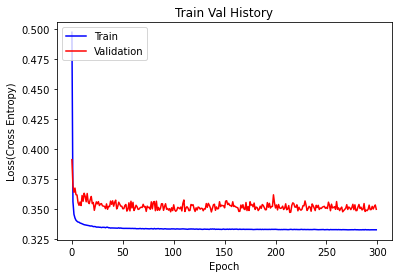

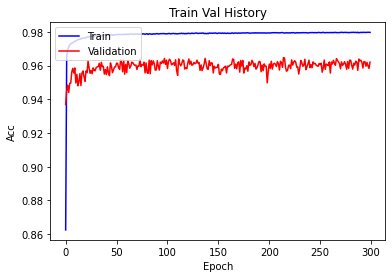

---- 5L_UNET_50_1channel_MAX_50hz_com0.252_T ----
----Loading data...
train_data shape: (42440, 6, 50)
train_ground shape: (42440, 6, 50)
test_data shape: (19680, 6, 50)
test_ground shape: (19680, 6, 50)
----Loading DONE!
----Normalized...
----Normalized Done
flops:  20304000.000000
params:  510.000000
Para num : 510
Train input: (42440, 1, 6, 50)
Train label: (42440, 6, 50)
Test input: (19680, 1, 6, 50)
Test label: (19680, 6, 50)
Epoch: 0 || Loss: 0.5292 || Acc: 0.8502  || Test_loss:0.4929 || Test_Acc:0.8243 || Time:42.5766 sec
Epoch: 1 || Loss: 0.3571 || Acc: 0.9636  || Test_loss:0.4041 || Test_Acc:0.9080 || Time:42.5480 sec
Epoch: 2 || Loss: 0.3447 || Acc: 0.9697  || Test_loss:0.3894 || Test_Acc:0.9220 || Time:42.3926 sec
Epoch: 3 || Loss: 0.3402 || Acc: 0.9733  || Test_loss:0.3754 || Test_Acc:0.9363 || Time:42.4553 sec
Epoch: 4 || Loss: 0.3383 || Acc: 0.9749  || Test_loss:0.3717 || Test_Acc:0.9399 || Time:42.4569 sec
Epoch: 5 || Loss: 0.3373 || Acc: 0.9757  || Test_loss:0.3696 || T

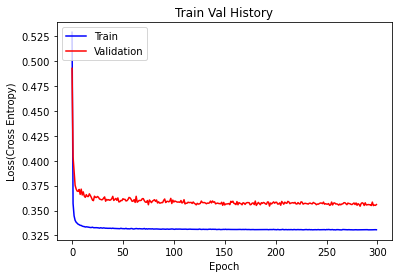

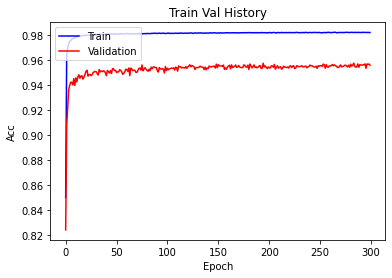

---- 5L_UNET_50_1channel_MAX_50hz_com0.253_T ----
----Loading data...
train_data shape: (43960, 6, 50)
train_ground shape: (43960, 6, 50)
test_data shape: (18160, 6, 50)
test_ground shape: (18160, 6, 50)
----Loading DONE!
----Normalized...
----Normalized Done
flops:  20304000.000000
params:  510.000000
Para num : 510
Train input: (43960, 1, 6, 50)
Train label: (43960, 6, 50)
Test input: (18160, 1, 6, 50)
Test label: (18160, 6, 50)
Epoch: 0 || Loss: 0.4575 || Acc: 0.9179  || Test_loss:0.3762 || Test_Acc:0.9476 || Time:42.1305 sec
Epoch: 1 || Loss: 0.3478 || Acc: 0.9716  || Test_loss:0.3577 || Test_Acc:0.9567 || Time:42.3008 sec
Epoch: 2 || Loss: 0.3407 || Acc: 0.9742  || Test_loss:0.3552 || Test_Acc:0.9578 || Time:42.2315 sec
Epoch: 3 || Loss: 0.3385 || Acc: 0.9753  || Test_loss:0.3566 || Test_Acc:0.9556 || Time:42.3278 sec
Epoch: 4 || Loss: 0.3370 || Acc: 0.9763  || Test_loss:0.3522 || Test_Acc:0.9599 || Time:42.4050 sec
Epoch: 5 || Loss: 0.3360 || Acc: 0.9771  || Test_loss:0.3528 || T

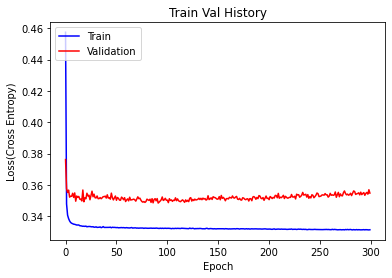

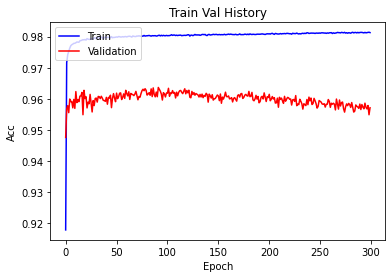

---- 5L_UNET_50_1channel_MAX_50hz_com0.25 Done ----


In [16]:

U_net = 0
early_acc = 0
for i in range(1,len(test_run)):
    for nor_mode in range(2,3):
        if nor_mode == 1:
            struc ="5L_UNET_50_1channel_Z_50hz"
        elif nor_mode == 2:
            struc ="5L_UNET_50_1channel_MAX_50hz_com0.25"
        else:
            struc ="5L_UNET_50_1channel_nNor_50hz"
        file_name = struc + str(i)+"_T"
        print ("\033[5;37;40m----",file_name,"----\033[0m")
        train_input,train_ground,test_input,test_ground = load_dataset(test_run[i])


        UNET_run(test_run[i],train_input,train_ground,test_input,test_ground)

print ("\033[5;37;31m----",struc, "Done","----\033[0m")